<a href="https://colab.research.google.com/github/nice-digital/nice-ds-kidneycancer/blob/master/kidneycancer/code/topicmodel_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic modelling on pre-processed dataset (Kidney cancer)**

This Colab notebook creates topic models on pre-processed datasets


**Inputs**
- Data file: Please note that the input data file should be the output of preproc colab or categorisation colab. Name your input file *input_data.csv*.

**Outputs**

- The interactive plots is a key output, as well as the excel spreadsheet produced process_model.csv in Results folder which provides information on the best topic associated with each study.

Upload the input file  by pressing the upload button on the top left of the left sidebar. The results will appear in a folder named *RESULTS*. RESULTS folder will be automatically created by the code

In [1]:
#@title Install Python packages { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to download and import third-party software
#@markdown in this Colab notebook.

#@markdown This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.
!pip install --upgrade pip
from IPython.utils import io
import subprocess

try:
  with io.capture_output() as captured:
    %shell pip install pyLDAvis==3.3.1
    %shell pip install import-ipynb
    %shell pip install pandas
    %shell pip install shutup

except subprocess.CalledProcessError:
  print(captured)
  raise
import shutup
shutup.please()

import os
import numpy as np
import pandas as pd
from pathlib import Path

from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


pd. set_option('display.max_colwidth', None)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title File settings to get started { form-width: "20%" }

#@markdown Please ensure the input_data.csv is uploaded and execute this cell by pressing the _Play_ button
#@markdown on the left
DATA_PATH = 'input_data.csv'

results_folder = 'RESULTS'
RESULTS_FOLDER = results_folder     #***user input
if not os.path.isdir(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
RESULTS_PATH = Path(RESULTS_FOLDER)

In [6]:
#@title Read input file  { form-width: "20%" }

def handle_listStrings(list_tokens):
  return(eval(list_tokens))

lit_data = pd.read_csv('input_data.csv')
#lit_data = df.loc[df['include'] > 0] # for kidneys dont need include line


lit_data['medTokens'] = lit_data.medTokens.apply(handle_listStrings)
lit_data['cancerTokens'] = lit_data.cancerTokens.apply(handle_listStrings)
lit_data['entTokens'] = lit_data.entTokens.apply(handle_listStrings)

In [ ]:
lit_data.shape[0]

822

In [7]:
#@title Function definitions for LDA model results { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button on the left

from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from math import ceil
from collections import Counter

def get_document_topic_table(lda_model, corpus):
  # Init output
  document_topic_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(lda_model[corpus]):   #i - abstract number, row_list: topic number and probability
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic_num=row[0][0]
    prop_topic=row[0][1]
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    document_topic_df.at[i,'best_topic']=topic_num
    document_topic_df.at[i,'prop_topic']=prop_topic
    document_topic_df.at[i,'topic_keywords']=topic_keywords
    document_topic_df.at[i,'document_num']=i
    document_topic_df.at[i,'topic_dist'] = str(row)

  return document_topic_df

def model_lda(dict, corpus):
  # Build LDA model
  lda_model = LdaModel(corpus=corpus, id2word=dict, num_topics=NUM_TOPICS, random_state=100,
                chunksize=200, passes=100)
  print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

  print("***Word distribution in topics***")
  lda_model.print_topics()[:NUM_TOPICS-1]


  return lda_model

def show_wordcloud(lda_model):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

  cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
  topics = lda_model.show_topics(formatted=False)
  ncol = 2
  nrow = ceil(NUM_TOPICS/ncol)
  fig, axes = plt.subplots(nrow, ncol, figsize=(10,10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
    ax.set_axis_off()
    if i == NUM_TOPICS:
      break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    # ax.set_axis_on()


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()


def show_wordimportance(lda_model, data):
  topics = lda_model_med.show_topics(formatted=False)
  data_flat = [w for w_list in data for w in w_list]
  counter = Counter(data_flat)
  out = []

  for i, topic in topics:
    for word, weight in topic:
      out.append([word, i , weight, counter[word]])

  df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
  ncol = 2
  nrow = ceil(NUM_TOPICS/ncol)

  # Plot Word Count and Weights of Topic Keywords
  fig, axes = plt.subplots(nrow, ncol, figsize=(16,20), sharey=True,dpi=160)
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
  for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.5); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

  fig.tight_layout(w_pad=5)


In [8]:
#@title Specify number of topics  { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button on the left

NUM_TOPICS = 4

In [9]:
#@title Specify exclusions { form-width: "20%" }

# Below are the list of irrelevant words for medical entity model
MED_IRRELEVANT = ['Cancer', 'Kidney cancer', 'cancer', 'kidney cancer', 'cancers', 'kidney cancers', 'objective(s', 'purpose(s', 'tumors', 'patients','patient', 'kidney cancer patients']

In [10]:
#@title LDA modelling on med tokens  { form-width: "20%" }
DATA = lit_data["medTokens"]
DATA = DATA.apply(lambda x: [y for y in x if y not in MED_IRRELEVANT])

DICTIONARY = Dictionary(DATA)
# Bag-of-words representation of the documents.
CORPUS = [DICTIONARY.doc2bow(doc) for doc in DATA]
lda_model_med = model_lda(DICTIONARY, CORPUS)

document_topic_df = get_document_topic_table(lda_model=lda_model_med, corpus=CORPUS)
lit_data.reset_index(drop=True, inplace=True)
document_topic_df.reset_index(drop = True, inplace=True)
out_df = pd.concat([lit_data, document_topic_df], axis = 1)
out_df.to_csv(RESULTS_PATH / "processed_model.csv", index=False)

lda_model_med.print_topics()[:NUM_TOPICS]



Perplexity:  -6.5377030333136625
***Word distribution in topics***


[(0,
  '0.034*"toxicity" + 0.033*"sunitinib" + 0.028*"tyrosine" + 0.027*"creatinine" + 0.020*"cisplatin" + 0.017*"rapamycin" + 0.017*"everolimus" + 0.017*"sorafenib" + 0.015*"renal cancer" + 0.015*"axitinib"'),
 (1,
  '0.020*"tumour" + 0.020*"pain" + 0.017*"breast cancer" + 0.016*"colorectal cancer" + 0.015*"calcium" + 0.014*"bleeding" + 0.013*"venous thromboembolism" + 0.013*"lung cancer" + 0.012*"sarcopenia" + 0.011*"melanoma"'),
 (2,
  '0.264*"renal cell carcinoma" + 0.121*"tumor" + 0.025*"vitamin d" + 0.023*"prostate cancer" + 0.016*"carcinoma" + 0.015*"renal cell carcinoma   renal cell carcinoma" + 0.015*"renal tumors" + 0.010*"blood loss" + 0.009*"ischemia" + 0.009*"systemic lupus erythematosus"'),
 (3,
  '0.047*"diabetes" + 0.037*"chronic kidney disease" + 0.024*"hypertension" + 0.023*"obesity" + 0.022*"death" + 0.021*"infection" + 0.020*"acute kidney injury" + 0.016*"diabetes mellitus" + 0.016*"cardiovascular disease" + 0.016*"malignancy"')]

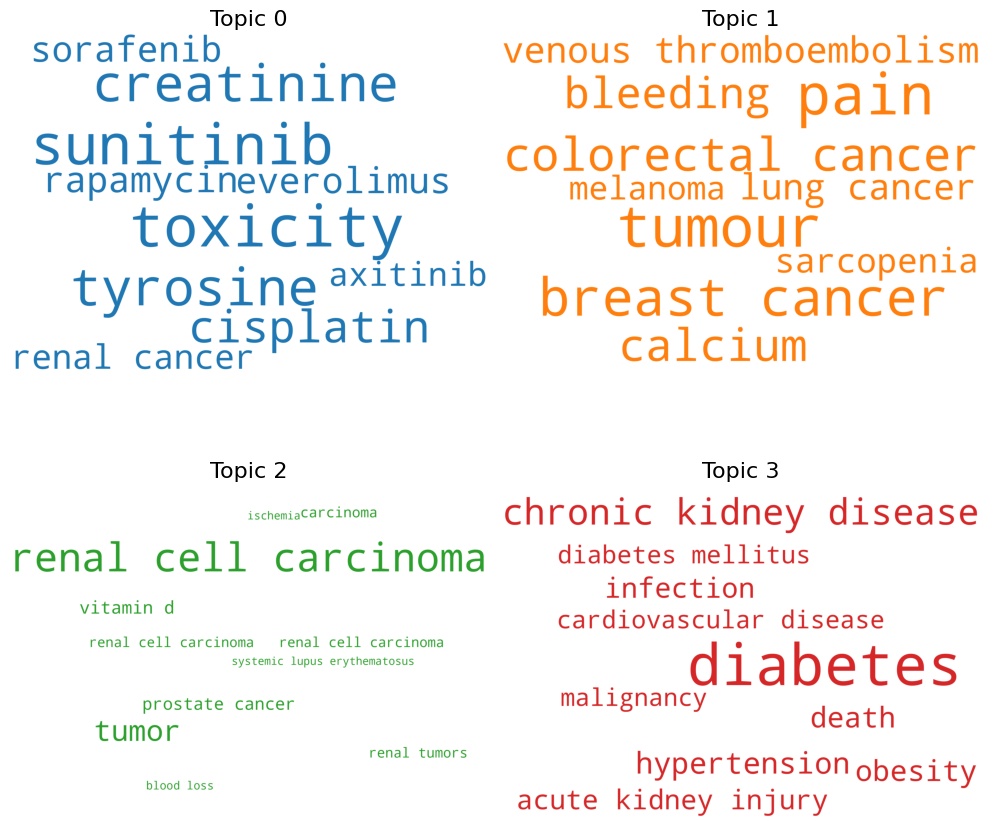

In [11]:
#@title Word cloud of topics  { form-width: "20%" }
show_wordcloud(lda_model_med)

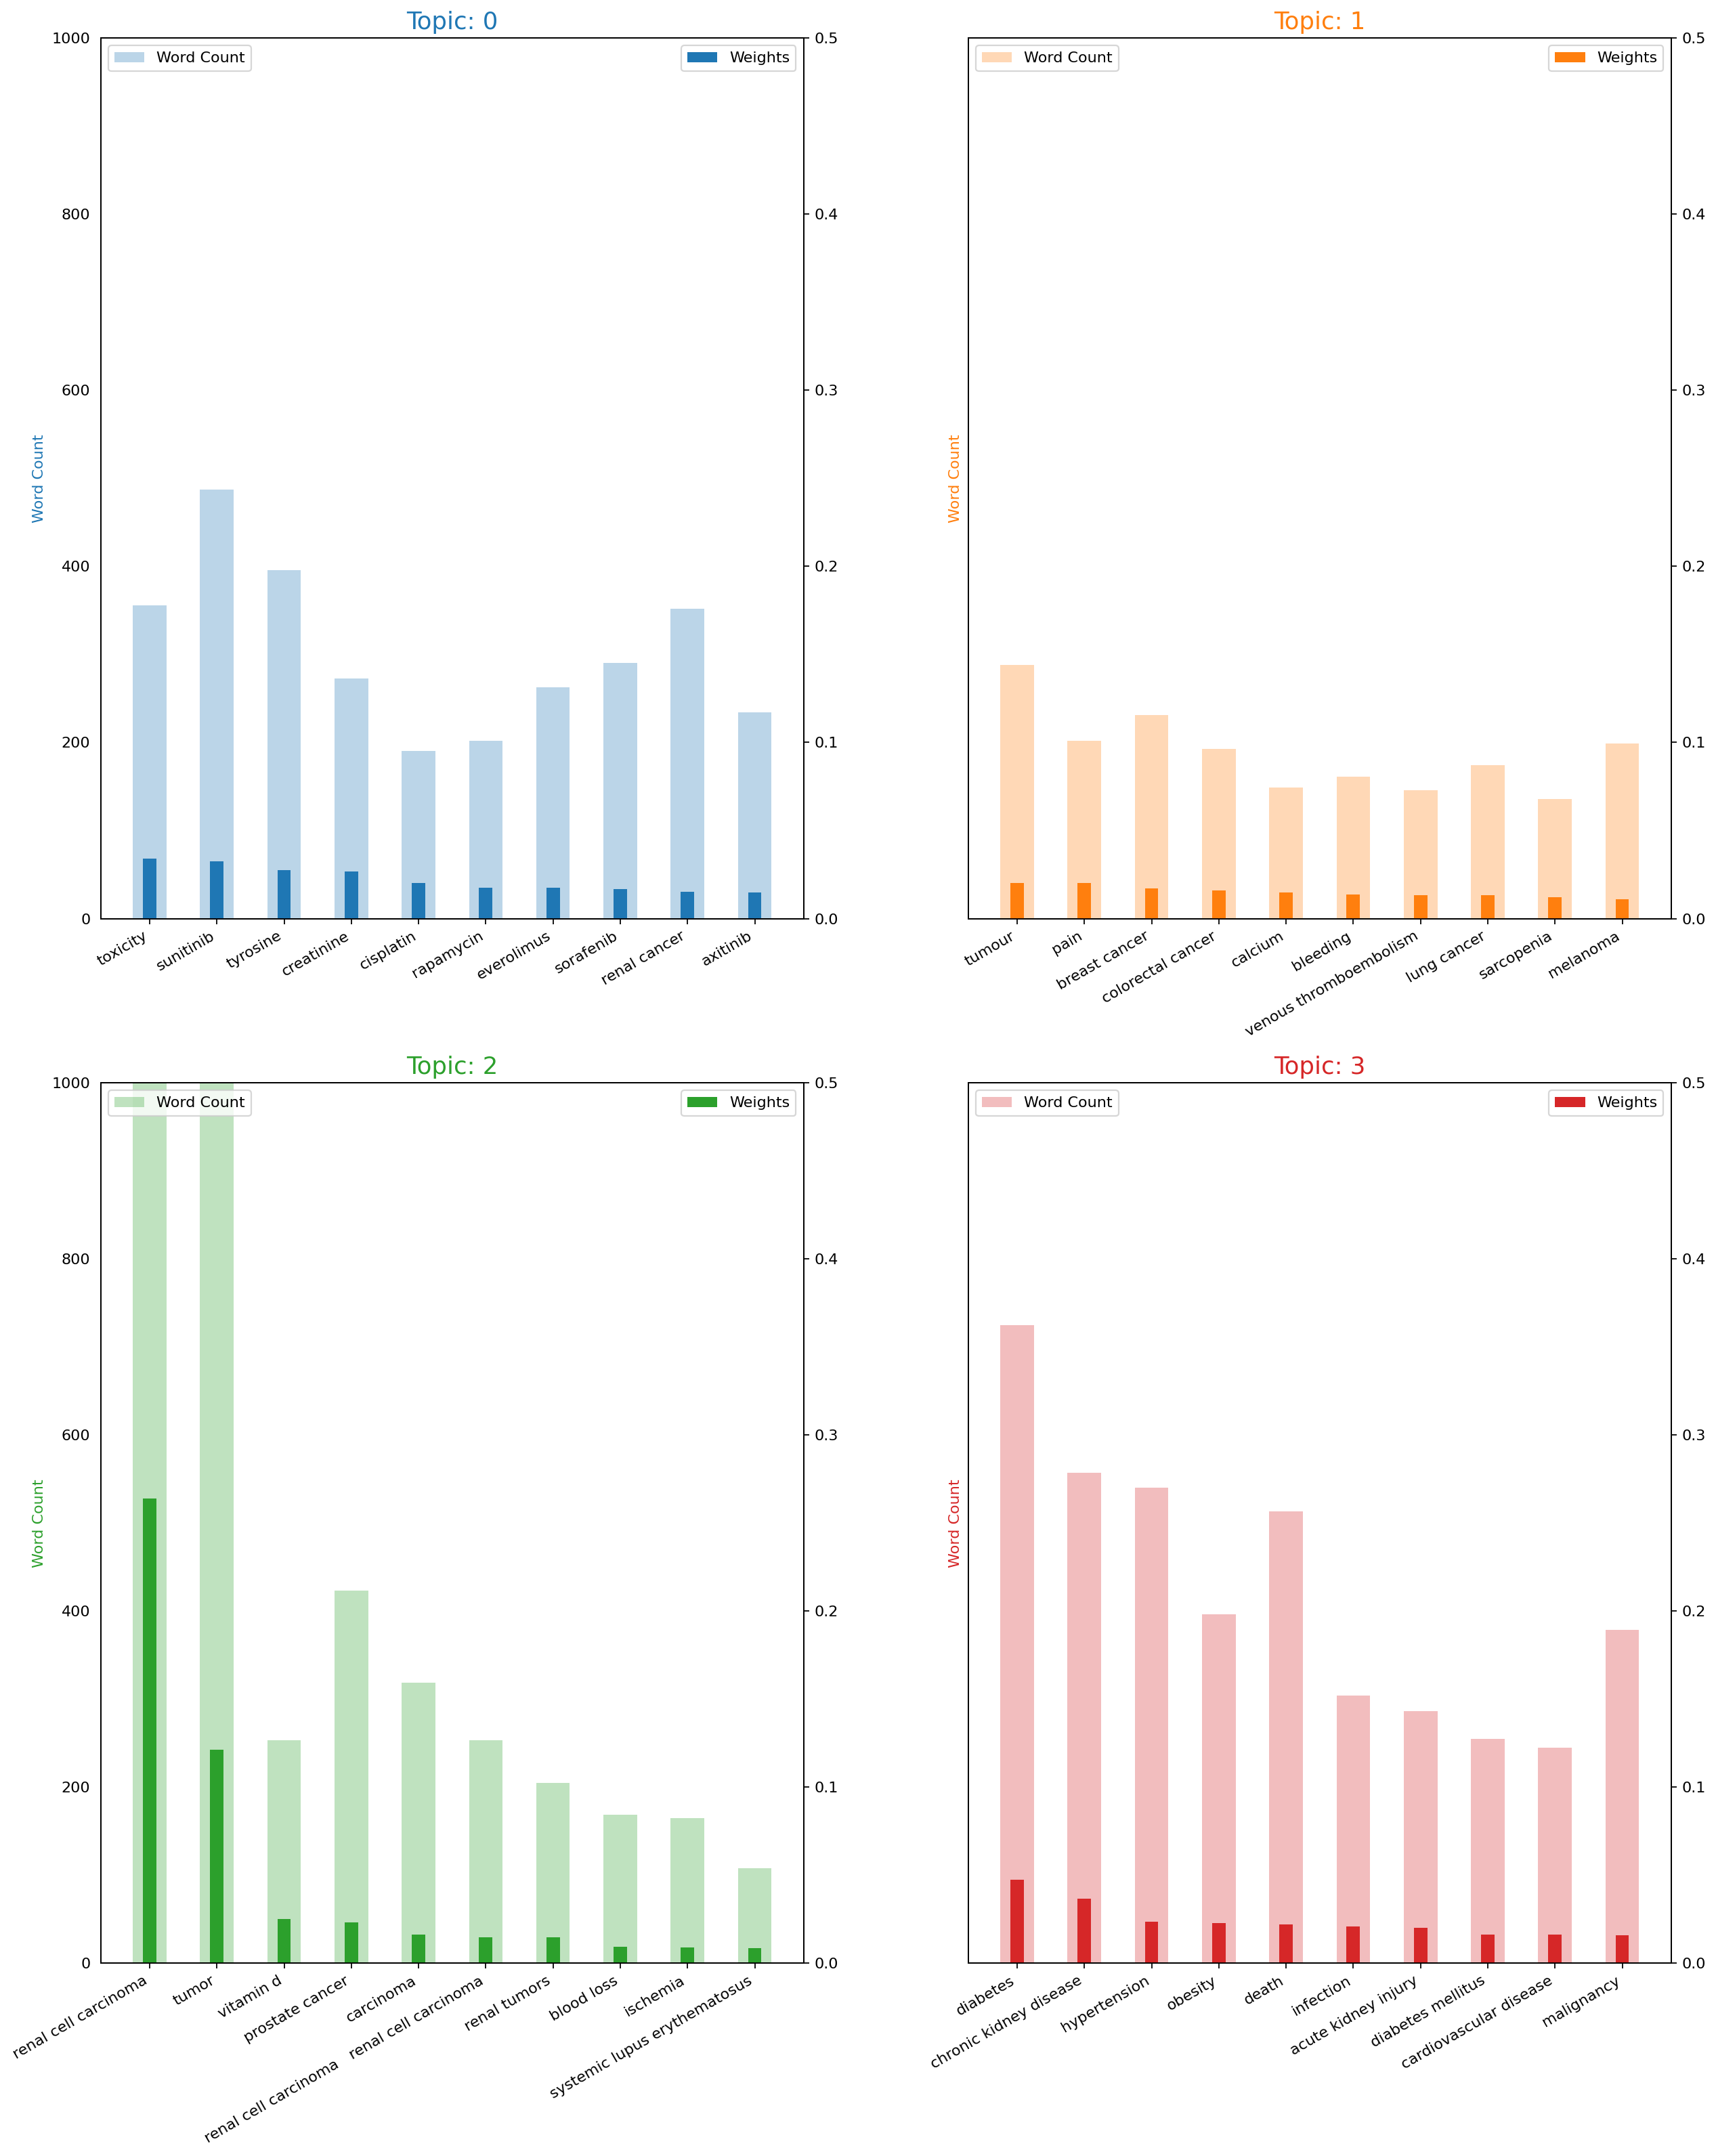

In [12]:
#@title Word importance in the topics  { form-width: "20%" }
show_wordimportance(lda_model_med, DATA)

In [13]:
#@title PyLDAVis  { form-width: "20%" }
vis = gensimvis.prepare(lda_model_med, CORPUS, dictionary=lda_model_med.id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.020736  0.256420       1        1  20.400978
1     -0.062909  0.070486       2        1  22.819468
2     -0.229183 -0.175460       3        1  24.456718
3      0.271356 -0.151445       4        1  32.322835, topic_info=                       Term         Freq        Total Category  logprob  \
23     renal cell carcinoma  2903.000000  2903.000000  Default  30.0000   
6                     tumor  1335.000000  1335.000000  Default  29.0000   
19                 diabetes   689.000000   689.000000  Default  28.0000   
59   chronic kidney disease   531.000000   531.000000  Default  27.0000   
115                toxicity   312.000000   312.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
328            inflammation   102.258608   112.315930   Topic4  -4.9564   
184                   death   320.068189   459.199413   Topic4  -3.8154   
299              malignancy   230.031916   318.492066   Topic4  -4.1457   
55           bladder cancer   126.686847   215.005362   Topic4  -4.7422   
332           renal disease    76.778251    85.044728   Topic4  -5.2430   

     loglift  
23   30.0000  
6    29.0000  
19   28.0000  
59   27.0000  
115  26.0000  
..       ...  
328   1.0356  
184   0.7684  
299   0.8040  
55    0.6005  
332   1.0271  

[174 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
3765      3  0.975235              abiraterone
513       2  0.971071  acute coronary syndrome
251       4  0.998539      acute kidney injury
213       2  0.965490                  anaemia
1073      1  0.679178                   anemia
...     ...       ...                      ...
498       3  0.998520                vitamin d
2975      3  0.990665     vitamin d deficiency
331       4  0.995522              weight loss
54        3  0.993286              wilms tumor
2413      3  0.985283          zoledronic acid

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])